# Using a Branched CNN and LSTM Model

This notebook is essentially the same as the bidirectional LSTM notebook expect we use a branched neural network. Our model follows precisely the one used in [Deep CNN-LSTM with Combined Kernels from Multiple
Branches for IMDb Review Sentiment Analysis](https://vermaabhi23.github.io/publication/2017UEMCON1.pdf) by Yenter and Verma. Their model outperformed existing models on the IMDB benchmark, so we tried using it here. Unfortunately it does not perform as well as the bidirectional LSTM, but branched neural networks may be something to explore in the future.

In [ ]:
#Comment this out if not in Google Colab
%tensorflow_version 1.x

In [ ]:
from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten, Input, BatchNormalization, Concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Model
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
%cd /content/drive/My\ Drive/

In [ ]:
import preprocessing
df = preprocessing.emotes_to_labels('summit1g', 1000)
print(df)

                                                      body  lul  ...  kappa  4head
21       [@thesocomsniper, if, you, think, oscp, is, ex...    1  ...      0      0
238      [@summit1g, lot, of, stupid, people, on, the, ...    1  ...      0      0
260                           [summit, not, in, the, bath]    1  ...      0      0
367              [@summit1g, ramhh, has, a, better, badge]    1  ...      0      0
610      [@summit1g, my, name, is, h1z1, and, im, utter...    1  ...      0      0
...                                                    ...  ...  ...    ...    ...
1349441                         [break, monitor, or, riot]    0  ...      1      0
1349515                             [pleaaaaassseeee, !!!]    0  ...      0      0
1349580   [hey, you, gonna, punch, your, camera, again, ?]    0  ...      1      0
1349613            [@summit1g, punch, the, monitor, again]    1  ...      0      0
1349706              [the, stupid, shit, board, i, forgot]    1  ...      0      0

[20

In [ ]:
Z = df['body'].values.tolist()

In [ ]:
Z = [' '.join(i) for i in Z]

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer(num_words=5000, filters='', split=' ', oov_token=5001)
t.fit_on_texts(Z)

In [ ]:
sequences = t.texts_to_sequences(Z)

In [ ]:
from sklearn.model_selection import train_test_split
X = sequences
y = np.array(df.iloc[:,1:len(df.columns)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify = y)

In [ ]:
top_words = 5000
max_words = 10
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

In [ ]:
rmsprop = RMSprop(lr=0.01, decay=0.1)

model1 = Sequential()
model1.add(Embedding(top_words, 32, input_length=max_words))
model1.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.5))
model1.add(BatchNormalization())
model1.add(LSTM(128))

model2 = Sequential()
model2.add(Embedding(top_words, 32, input_length=max_words))
model2.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(LSTM(128))

model3 = Sequential()
model3.add(Embedding(top_words, 32, input_length=max_words))
model3.add(Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=l2(0.01)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.5))
model3.add(BatchNormalization())
model3.add(LSTM(128))

model4 = Sequential()
model4.add(Embedding(top_words, 32, input_length=max_words))
model4.add(Conv1D(filters=128, kernel_size=9, activation='relu', kernel_regularizer=l2(0.01)))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Dropout(0.5))
model4.add(BatchNormalization())
model4.add(LSTM(128))

merged = Concatenate()([model1.output,model2.output,model3.output,model4.output])
merged = Dense(len(df.columns)-1, activation='softmax')(merged)
model = Model([model1.input,model2.input,model3.input,model4.input], merged)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model.fit([X_train,X_train,X_train,X_train], y_train, validation_data=([X_test,X_test,X_test,X_test], y_test), epochs=15, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 26460 samples, validate on 26464 samples
Epoch 1/15
 - 32s - loss: 0.5612 - acc: 0.7551 - f1_m: 0.0782 - precision_m: 0.5907 - recall_m: 0.0428 - val_loss: 0.5351 - val_acc: 0.7568 - val_f1_m: 0.0775 - val_precision_m: 0.4759 - val_recall_m: 0.0434
Epoch 2/15
 - 23s - loss: 0.5274 - acc: 0.7583 - f1_m: 0.1238 - precision_m: 0.6329 - recall_m: 0.0701 - val_loss: 0.5300 - val_acc: 0.7592 - val_f1_m: 0.1454 - val_precision_m: 0.5456 - val_recall_m: 0.0862
Epoch 3/15
 - 23s - loss: 0.5188 - acc: 0.7621 - f1_m: 0.1689 - precision_m: 0.6579 - recall_m: 0.0989 - val_loss: 0.5282 - val_acc: 0.7598 - val_f1_m: 0.1704 - val_precision_m: 0.5502 - val_recall_m: 0.1037
Epoch 4/15
 - 22s - loss: 0.5136 - acc: 0.7643 - f1_m: 0.1928 - precision_m: 0.6654 - recall_m: 0.1151 - val_loss: 0.5270 - val_acc: 0.7603 - val_f1_m: 0.1901 - val_precision_m: 0.5475 - val_recall_m: 0.1179
Epoch 5/15
 - 23s - los

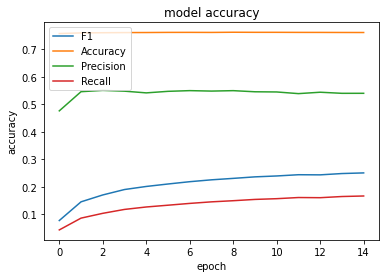

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_f1_m'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_precision_m'])
plt.plot(history.history['val_recall_m'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['F1', 'Accuracy','Precision','Recall'], loc='upper left')
plt.show()

['body', 'lul', 'pogchamp', 'kappa', '4head']


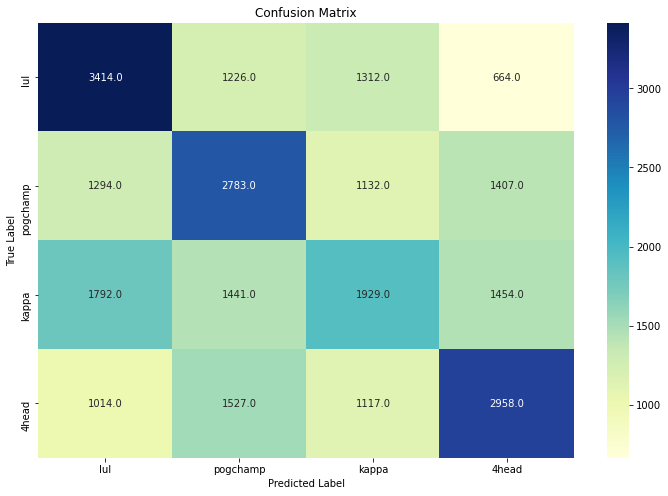

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

X = list(df.columns)
print(X)

y_pred = model.predict([X_test,X_test,X_test,X_test])
y_pred_class = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)

confusion = confusion_matrix(y_true, y_pred_class)

f, ax = plt.subplots(figsize= (12,8))
sns.heatmap(confusion, annot = True, cmap = "YlGnBu", ax = ax, fmt= '.1f',xticklabels=X[1:], yticklabels=X[1:])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()